# Mask Detection – Preprocessing, Split (8-1-1) and Training with MobileNetV2

## 1. Import libraries

In [110]:

import os
import random
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
import kagglehub





In [114]:
# Directory paths
data_dir = "./data"
raw_data_dir = "./data"
input_dir = "./data"
output_dir = "./split_data"
processed_dir = "pre_train"
train_dir = "./pre_train/train"
val_dir = "./pre_train/val"
test_dir = "./pre_train/test"

# Model paths
face_detector_proto = "models/deploy.prototxt"
face_detector_model = "models/res10_300x300_ssd_iter_140000.caffemodel"

# Image processing configurations
image_size = (224, 224)
classes = ("with_mask", "without_mask")
num_images = 3

# Data split ratios
splits = {"train": 0.8, "val": 0.1, "test": 0.1}

# Training parameters
batch_size = 32
epochs = 10

In [ ]:
#Download dataset

if not os.path.exists(data_dir):
    path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
    shutil.copytree(path, ".")
    print("Dataset copy vào thư mục data/")
else:
    print("Dataset đã tồn tại")

Dataset copy vào thư mục data/


## 2. Unzip dataset

In [95]:

def unzip_dataset(zip_path, extract_dir):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Không tìm thấy file: {zip_path}")

    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"Đã giải nén {zip_path} vào {extract_dir}")
unzip_dataset("./data.zip", ".")

Đã giải nén ./data.zip vào .


## 3. Function to show sample images

In [96]:

def show_samples(data_dir, classes=("with_mask", "without_mask"), num_images=3):
    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        images = [
            f for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ][:num_images]

        for img_name in images:
            img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
            plt.subplot(len(classes), num_images, idx)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            idx += 1

    plt.show()


## 4. Show images after unzip

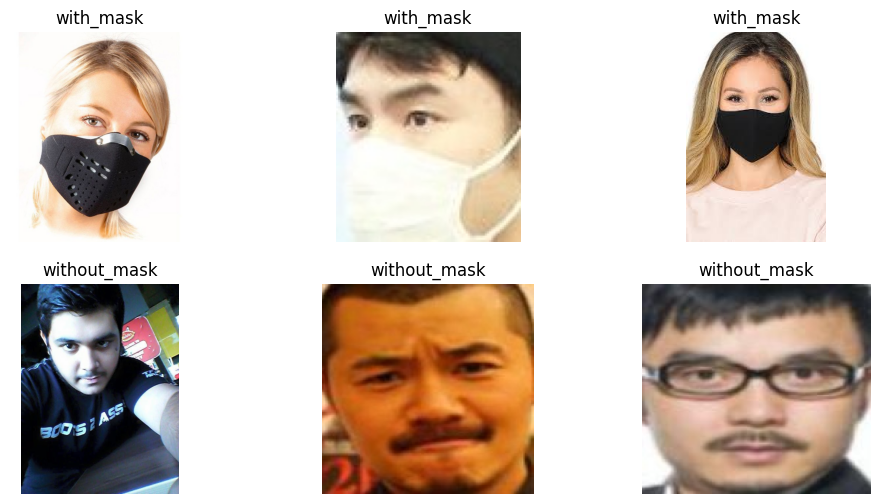

In [97]:

show_samples(raw_data_dir)


## 5. Split data (8-1-1)

In [98]:

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * splits["train"])
    n_val = int(n_total * splits["val"])

    split_dict = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split, split_images in split_dict.items():
        split_cls_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)

        for img in split_images:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_cls_dir, img)
            )


## 6. Show images after split (train set)

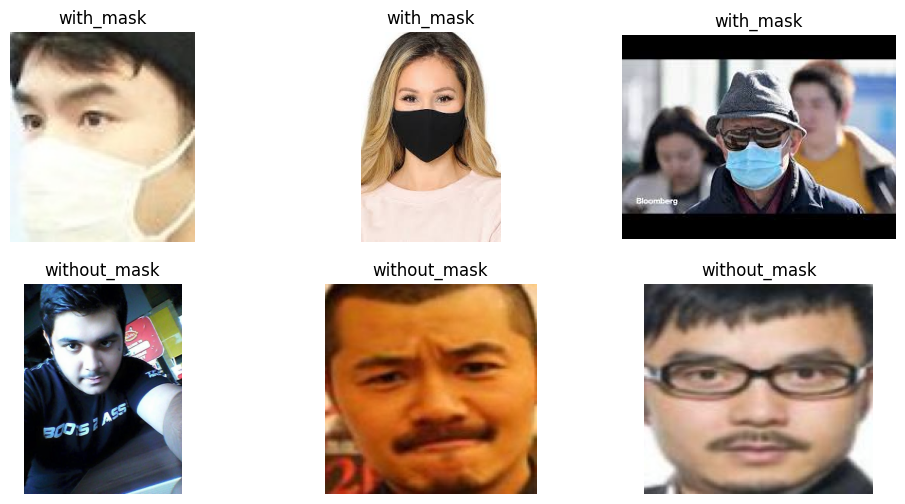

In [99]:

show_samples("./split_data/train")


## 7.  preprocessing

In [100]:
import os
import cv2
import numpy as np
from PIL import Image
import hashlib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

os.makedirs(processed_dir, exist_ok=True)

# Load OpenCV DNN face detector
net = cv2.dnn.readNetFromCaffe(
    face_detector_proto,
    face_detector_model
)

hashes = set()

def is_duplicate(img_array):
    h = hashlib.md5(img_array.tobytes()).hexdigest()
    if h in hashes:
        return True
    hashes.add(h)
    return False


for root, dirs, files in os.walk(input_dir):
    # giữ nguyên cấu trúc thư mục
    relative_path = os.path.relpath(root, input_dir)
    output_root = os.path.join(processed_dir, relative_path)
    os.makedirs(output_root, exist_ok=True)

    for file in files:
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(root, file)

        frame = cv2.imread(img_path)
        if frame is None:
            continue

        h, w = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(
            cv2.resize(frame, (300, 300)),
            1.0,
            (300, 300),
            (104.0, 177.0, 123.0)
        )

        net.setInput(blob)
        detections = net.forward()

        for i in range(detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf < 0.6:
                continue

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype("int")

            # clamp bounding box
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            face = frame[y1:y2, x1:x2]
            if face.size == 0:
                continue

            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, size)

            img_array = np.array(face).astype("float32")

            if is_duplicate(img_array):
                break

            img_array = preprocess_input(img_array)

            img_save = Image.fromarray(
                ((img_array + 1) / 2 * 255).astype("uint8")
            )

            img_save.save(os.path.join(output_root, file))
            break  # chỉ lấy 1 khuôn mặt


## 8. Show after preprocess

In [101]:
classes = ("with_mask", "without_mask")
num_images = 3
processed_dir = "./pre_train/test"
plt.figure(figsize=(12, 6))
idx = 1

for cls in classes:
    cls_dir = os.path.join(processed_dir, cls)
    images = [
        f for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ][:num_images]

    for img_name in images:
        img = Image.open(os.path.join(cls_dir, img_name)).convert("RGB")
        img = np.array(img).astype("float32") / 255.0
        plt.subplot(len(classes), num_images, idx)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        idx += 1

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './pre_train/test/with_mask'

<Figure size 1200x600 with 0 Axes>

## 9. Load data for MobileNetV2

In [ ]:

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 5514 images belonging to 2 classes.
Found 719 images belonging to 2 classes.
Found 719 images belonging to 2 classes.
Found 713 images belonging to 2 classes.
Found 713 images belonging to 2 classes.


## 10. Build MobileNetV2 model

In [ ]:

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


## 11. Train model

In [ ]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 272ms/step - accuracy: 0.9770 - loss: 0.0582 - val_accuracy: 0.9875 - val_loss: 0.0742
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 272ms/step - accuracy: 0.9770 - loss: 0.0582 - val_accuracy: 0.9875 - val_loss: 0.0742
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.9946 - loss: 0.0180 - val_accuracy: 0.9861 - val_loss: 0.0696
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.9946 - loss: 0.0180 - val_accuracy: 0.9861 - val_loss: 0.0696
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 294ms/step - accuracy: 0.9960 - loss: 0.0146 - val_accuracy: 0.9861 - val_loss: 0.0725
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 294ms/step - accuracy: 0.9960 - loss: 0.0146 - val_accuracy: 0.9861 - val_loss: 0.0725
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9861 - val_loss: 0.0716
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.9982 - loss: 0

## 12. Evaluate on test set and save

In [ ]:

model.evaluate(test_gen)
model.save("mask_mobilenet.h5")



23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9916 - loss: 0.0426
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9916 - loss: 0.0426
